In [1]:
!pip install torch torchvision numpy matplotlib scikit-learn


In [2]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [51]:
class ModelNet10Dataset(Dataset):
    def __init__(self, data_dir, split='train', num_points=1024):
        """
        Args:
            data_dir (str): Path to the ModelNet10 dataset.
            split (str): 'train' or 'test'.
            num_points (int): Number of points to sample from each point cloud.
        """
        self.data_dir = data_dir
        self.split = split
        self.num_points = num_points
        self.classes = sorted(os.listdir(self.data_dir))
        self.files = []

        for label, category in enumerate(self.classes):
            category_path = os.path.join(self.data_dir, category, self.split)
            if not os.path.exists(category_path):
                continue
            for file in os.listdir(category_path):
                if file.endswith('.off'):
                    self.files.append((os.path.join(category_path, file), label))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        points = load_off_file(file_path)

        # Normalize
        points -= np.mean(points, axis=0)
        points /= np.max(np.linalg.norm(points, axis=1))

        # Sample
        if points.shape[0] < self.num_points:
            sampled_indices = np.random.choice(points.shape[0], self.num_points, replace=True)
        else:
            sampled_indices = np.random.choice(points.shape[0], self.num_points, replace=False)

        return torch.tensor(points[sampled_indices], dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [52]:
DATA_DIR = '/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10'

train_dataset = ModelNet10Dataset(data_dir=DATA_DIR, split='train')
test_dataset = ModelNet10Dataset(data_dir=DATA_DIR, split='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 3991, Testing samples: 908


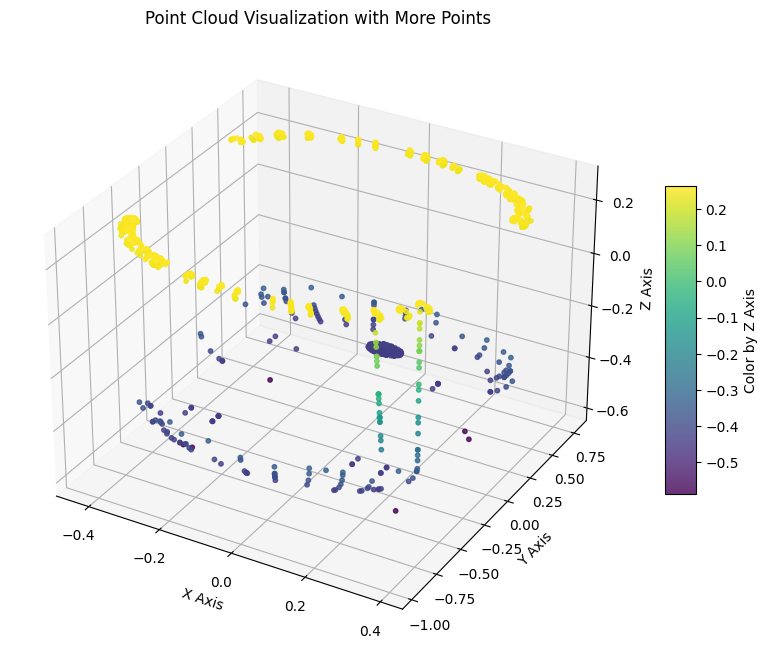

In [26]:
def visualize_point_cloud(points, num_points=2048):
    """
    Visualize a 3D point cloud with more points.
    Args:
        points (numpy.ndarray): Array of shape (N, 3) representing the point cloud.
        num_points (int): Number of points to visualize.
    """
    # Ensure we sample the specified number of points
    if points.shape[0] > num_points:
        sampled_indices = np.random.choice(points.shape[0], num_points, replace=False)
        points = points[sampled_indices]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with color based on Z-axis
    scatter = ax.scatter(
        points[:, 0], points[:, 1], points[:, 2],
        c=points[:, 2], cmap='viridis', s=10, alpha=0.8
    )

    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label("Color by Z Axis")

    # Set labels and title
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Point Cloud Visualization with More Points")
    
    plt.show()

# Visualize a random point cloud with more points from the training dataset
sample_points, _ = train_dataset[1]
visualize_point_cloud(sample_points.numpy(), num_points=2048)


In [48]:
def forward(self, x):
    print(f"Input shape: {x.shape}")  # Expect (B, N, 3)

    x_gc1 = F.relu(self.graph_conv1(x))  
    print(f"After GraphConv1: {x_gc1.shape}")  # Expect (B, N, 64)

    x_gc2 = F.relu(self.graph_conv2(x_gc1))  
    print(f"After GraphConv2: {x_gc2.shape}")  # Expect (B, N, 128)

    x_trans1 = self.transformer_block1(x_gc2)  
    print(f"After Transformer1: {x_trans1.shape}")  # Expect (B, N, 128)

    x_trans2 = self.transformer_block2(x_trans1)  
    print(f"After Transformer2: {x_trans2.shape}")  # Expect (B, N, 128)


In [53]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (B, N, D)
        Returns:
            Updated tensor of shape (B, N, D)
        """
        # Multi-Head Self Attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)  # Residual connection

        # Feedforward network
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)  # Residual connection
        return x


In [54]:
class AdaptiveGraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (B, N, C)
        Returns:
            Tensor of shape (B, N, D)
        """
        return self.fc(x)


In [55]:
class AFGTNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Graph Convolutions
        self.graph_conv1 = AdaptiveGraphConvolution(3, 64) 
        self.graph_conv2 = AdaptiveGraphConvolution(64, 128) 

        # Transformer Blocks
        self.transformer_block1 = TransformerBlock(128)  
        self.transformer_block2 = TransformerBlock(128)  

        # Global Pooling
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x_gc1 = F.relu(self.graph_conv1(x))  
        x_gc2 = F.relu(self.graph_conv2(x_gc1))  

        x_trans1 = self.transformer_block1(x_gc2)  
        x_trans2 = self.transformer_block2(x_trans1)  

        x_max_pool = self.global_max_pooling(x_trans2.permute(0, 2, 1)).squeeze(-1)
        x_avg_pool = self.global_avg_pooling(x_trans2.permute(0, 2, 1)).squeeze(-1)

        x_concat = torch.cat([x_max_pool, x_avg_pool], dim=1)

        logits = self.fc_layers(x_concat)  
        return logits


In [56]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for points_batch, labels_batch in train_loader:
        points_batch, labels_batch = points_batch.to(device), labels_batch.to(device)

        outputs = model(points_batch)
        loss = criterion(outputs, labels_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_predictions += (predicted_labels == labels_batch).sum().item()
        total_samples += labels_batch.size(0)

    return total_loss / len(train_loader), (correct_predictions / total_samples) * 100


def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for points_batch, labels_batch in test_loader:
            points_batch, labels_batch = points_batch.to(device), labels_batch.to(device)

            outputs = model(points_batch)
            loss = criterion(outputs, labels_batch)

            total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_predictions += (predicted_labels == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

    return total_loss / len(test_loader), (correct_predictions / total_samples) * 100


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AFGTNet(num_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = test_model(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/20
Train Loss: 1.1238, Train Accuracy: 61.36%
Test Loss: 0.8714, Test Accuracy: 69.05%
Epoch 2/20
Train Loss: 0.6318, Train Accuracy: 78.48%
Test Loss: 0.7760, Test Accuracy: 71.15%
Epoch 3/20
Train Loss: 0.5231, Train Accuracy: 81.86%
Test Loss: 0.6127, Test Accuracy: 74.78%
Epoch 4/20
Train Loss: 0.4675, Train Accuracy: 84.26%
Test Loss: 0.6712, Test Accuracy: 76.76%
Epoch 5/20
Train Loss: 0.4286, Train Accuracy: 85.17%
Test Loss: 0.7139, Test Accuracy: 74.67%
Epoch 6/20
Train Loss: 0.3966, Train Accuracy: 86.14%
Test Loss: 0.5446, Test Accuracy: 81.06%
Epoch 7/20
Train Loss: 0.3778, Train Accuracy: 86.70%
Test Loss: 0.5719, Test Accuracy: 80.40%
Epoch 8/20
Train Loss: 0.3485, Train Accuracy: 87.95%
Test Loss: 0.5674, Test Accuracy: 79.52%
Epoch 9/20
Train Loss: 0.3414, Train Accuracy: 87.75%
Test Loss: 0.5122, Test Accuracy: 83.59%
Epoch 10/20
Train Loss: 0.3149, Train Accuracy: 89.45%
Test Loss: 0.5457, Test Accuracy: 80.29%
Epoch 11/20
Train Loss: 0.3179, Train Accuracy: 8

In [58]:
torch.save(model.state_dict(), "afgtnet_model.pth")
print("Model saved as afgtnet_model.pth")


Model saved as afgtnet_model.pth


In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_model(model, test_loader, criterion):
    """
    Evaluate the AFGTNet model on the test dataset and compute various metrics.

    Args:
        model: The trained AFGTNet model.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function (e.g., CrossEntropyLoss).

    Returns:
        avg_loss: Average test loss.
        accuracy: Test accuracy.
        precision: Precision score.
        recall: Recall score.
        f1: F1-score.
        conf_matrix: Confusion matrix.
    """
    model.eval()  
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for points_batch, labels_batch in test_loader:
            points_batch, labels_batch = points_batch.to(device), labels_batch.to(device)

            # Forward pass
            outputs = model(points_batch)

            # Compute loss
            loss = criterion(outputs, labels_batch)
            total_loss += loss.item()

            # Get predicted labels
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_predictions += (predicted_labels == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

            # Store predictions and labels for metrics
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100.0

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, conf_matrix


Test Loss: 0.5658
Test Accuracy: 81.94%
Precision: 0.8241
Recall: 0.7942
F1-score: 0.7957


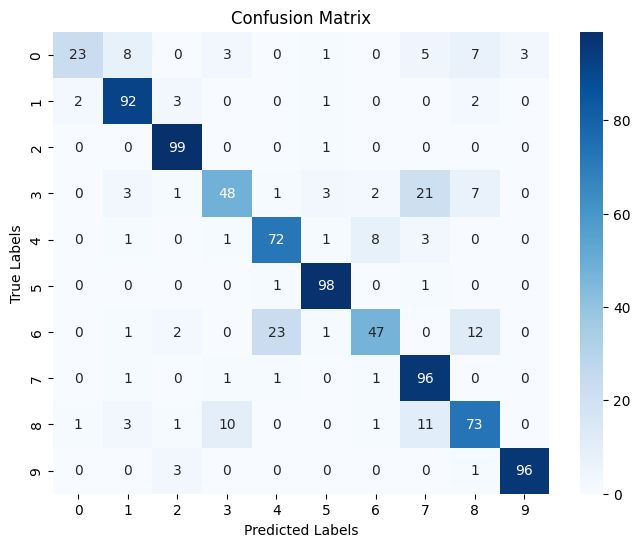

In [64]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Evaluate model
test_loss, test_accuracy, precision, recall, f1, conf_matrix = test_model(model, test_loader, criterion)

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Display Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
